In [2]:
'''Import necessary libraries, classes 
and functions from model.py and utils.py'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from utils import *
from model import *
import matplotlib.pyplot as plt

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


In [4]:
# Train data transformations
'''
Compose - Used to conduct a series of transformations 
RandomApply - Apply randomly a list of transformations with a given probability of 0.1
CenterCrop - Crops the given tensor image at the center. The crop size is 22 for square crop
Resize - Resize the input image to the given size. The given size is (28,28) for rectangular crop.
RandomRotation - Rotates an image by a range of angles to (-15.,-15.). Pixel fill(fill) value 
is for the area outside the rotated image
ToTensor - This is typically used to convert the input data(which is in form of numpy array or PIL image)
into a tensor format
Normalize - This will take the tensor image and normalize it with the mean and std dev to help
the data be within the range and reduce the skewness in order to learn faster and better.
This normalizes the tensor with a mean of 0.1307 and standard deviation of 0.3081
'''
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
#load train and test data of MNIST
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [6]:
# dataloader arguments
'''
kwargs - Dictionary of keywords arguments
shuffle - Indicates that the data will not be shuffled at every epoch when its being loaded
num_workers - Number of subprocesses to use for data loading. In this case the data loader will create
2 worker processes or threads. Each worker will independently load data from the dataset in the 
background. This form of parallelism will speed up the data loading process, especially when the 
data loading operation is CPU-intensive such as reading large files from disk or performing
complex transformations on the data.
'''
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

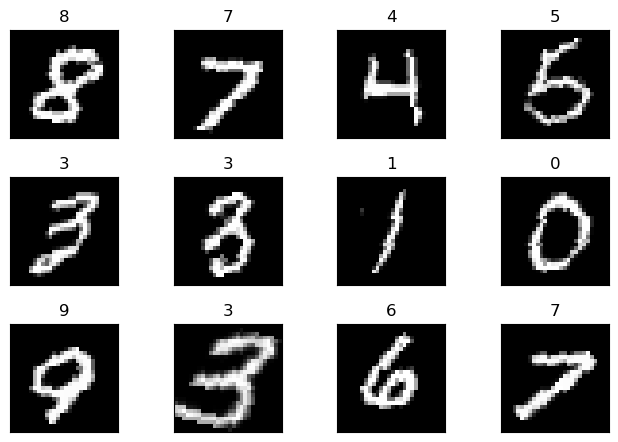

In [7]:
# Visualize some of the training data in batches

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [8]:
# Using Mac M1 GPU to run the model
'''Initializes an instance of the 'Net'
class and move it to the GPU to allow faster computation'''
use_mps = torch.backends.mps.is_available()
device = torch.device("mps:0" if use_mps else "cpu")
# Calling the network class from model.py and printing the summary
model = Net().to(device)
model_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [9]:
# Using SGD optimizer with momentum and StepLR scheduler
'''Optimizer is set up to train the model. 'model.parameters()' provides
the weight and biases of the model it should be updating. Momentum helps
accelerate SGD in the relevant direction and dampens oscillation'''
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
'''Stochastic gradient descent randomly selects a small batch of data points
at each step to compute the gradient. This introduces some noise into the gradient
estimate, but in exchange, it allows for much faster computations and make the learning
process more efficient, especially for large dataset.'''

'''StepLR scheduler is used to decay the learning rate of each parameter group by gamma'''
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# Using CrossEntropyLoss as the loss function
criterion = nn.CrossEntropyLoss()
num_epochs = 20
# Training and testing the model
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, nn.CrossEntropyLoss(reduction='sum'))
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2314 Batch_id=117 Accuracy=19.95: 100%|██████████| 118/118 [00:13<00:00,  8.52it/s]


Test set: Average loss: 2.2142, Accuracy: 1606/10000 (16.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.5493 Batch_id=117 Accuracy=47.01: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Test set: Average loss: 0.3227, Accuracy: 9095/10000 (90.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2938 Batch_id=117 Accuracy=92.23: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.1239, Accuracy: 9606/10000 (96.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0811 Batch_id=117 Accuracy=95.44: 100%|██████████| 118/118 [00:13<00:00,  9.08it/s]


Test set: Average loss: 0.0854, Accuracy: 9738/10000 (97.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0695 Batch_id=117 Accuracy=96.57: 100%|██████████| 118/118 [00:13<00:00,  8.77it/s]


Test set: Average loss: 0.0644, Accuracy: 9798/10000 (97.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0159 Batch_id=117 Accuracy=97.27: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Test set: Average loss: 0.0505, Accuracy: 9834/10000 (98.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0541 Batch_id=117 Accuracy=97.42: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]


Test set: Average loss: 0.0478, Accuracy: 9850/10000 (98.50%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0403 Batch_id=117 Accuracy=97.67: 100%|██████████| 118/118 [00:13<00:00,  8.95it/s]


Test set: Average loss: 0.0470, Accuracy: 9843/10000 (98.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0144 Batch_id=117 Accuracy=97.93: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]


Test set: Average loss: 0.0541, Accuracy: 9823/10000 (98.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1456 Batch_id=117 Accuracy=98.05: 100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


Test set: Average loss: 0.0357, Accuracy: 9880/10000 (98.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1077 Batch_id=117 Accuracy=98.18: 100%|██████████| 118/118 [00:12<00:00,  9.17it/s]


Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0334 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]


Test set: Average loss: 0.0346, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0455 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:13<00:00,  9.04it/s]


Test set: Average loss: 0.0360, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0697 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:13<00:00,  9.01it/s]


Test set: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0551 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Test set: Average loss: 0.0281, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0486 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0241 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0589 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0399 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:13<00:00,  9.00it/s]


Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0090 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:13<00:00,  9.01it/s]


Test set: Average loss: 0.0245, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-03.


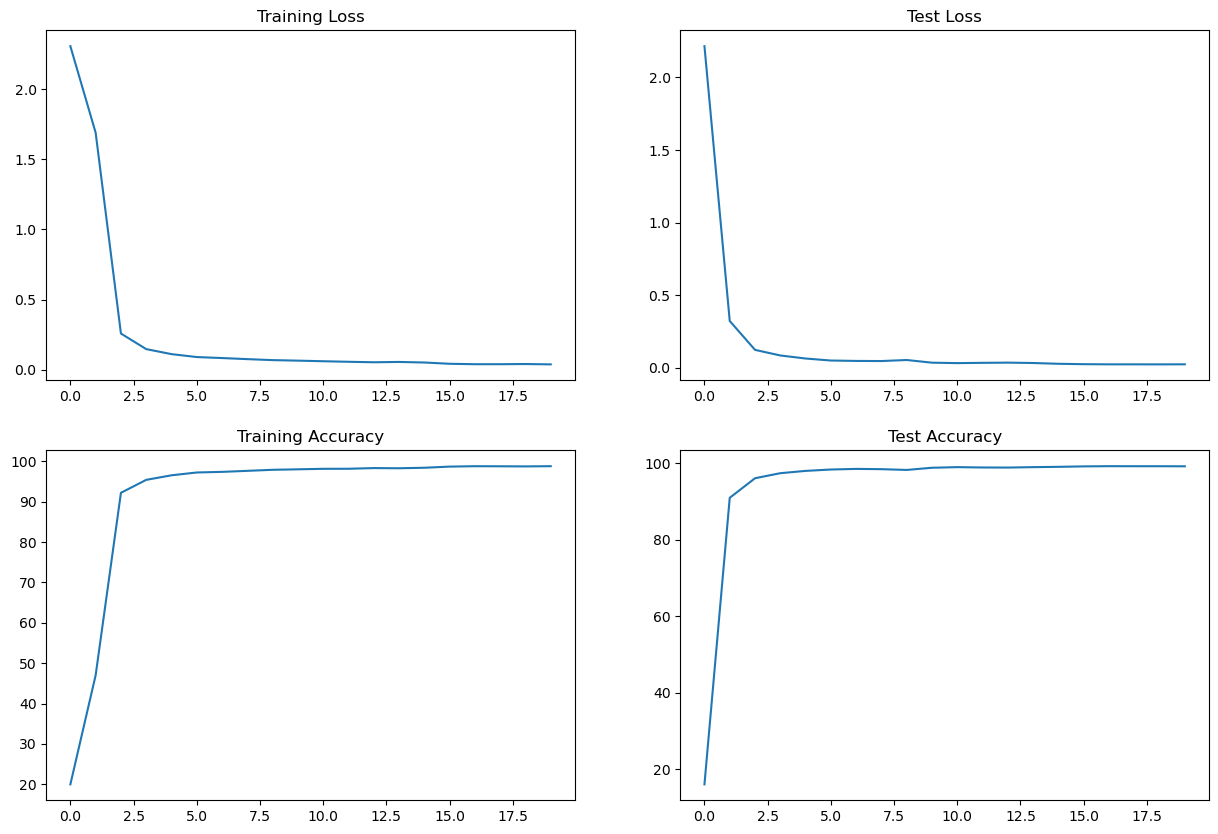

In [10]:
plt_fig(train_losses,train_acc,test_losses,test_acc)